In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from geopy.geocoders import Nominatim # for latitudes and longitudes


set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.2.4
Sklearn  0.24.2


### Importing Dataset

In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "umutakta"
    os.environ['KAGGLE_KEY']      = "a471e5474add8d57cadac3cc5ff2b1d6"  
    !pip install --upgrade kaggle
    !kaggle competitions download -c competitive-data-science-predict-future-sales
    DATA_PATH = "/work/Strive_School/Feature_Engineering_(Module_4)/Day_6_Feature_Selection/competitive-data-science-predict-future-sales/"

else:
    DATA_PATH = "/work/Data_Sets/competitive-data-science-predict-future-sales/"

DATA_PATH

'/work/Data_Sets/competitive-data-science-predict-future-sales/'

**Creating Data Frame**

In [32]:
df_item_categ=pd.read_csv(DATA_PATH+"item_categories.csv")
df_items=pd.read_csv(DATA_PATH+"items.csv")
df=pd.read_csv(DATA_PATH+"sales_train.csv")
df_sample=pd.read_csv(DATA_PATH+"sample_submission.csv")
df_shops=pd.read_csv(DATA_PATH+"shops_eng.csv")
df_test=pd.read_csv(DATA_PATH+"test.csv")

In [4]:
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

Turning date column to **date type**

In [5]:
from datetime import datetime

df["date"]=df['date'].apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))


### Deleting Outliers

**Item Count Day**

In [6]:
df=df.drop(df.loc[df.item_cnt_day<0].index.tolist())

<AxesSubplot:xlabel='item_cnt_day'>

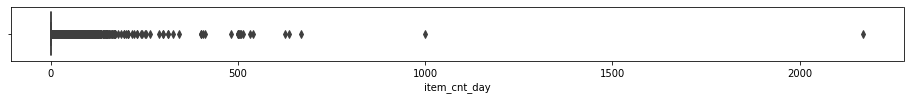

In [7]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_cnt_day)

**Item Price**

In [8]:
for i in range(5):
    df=df.drop(df.index[df.loc[df.item_price==df.item_price.max()].index[0]])

<AxesSubplot:xlabel='item_price'>

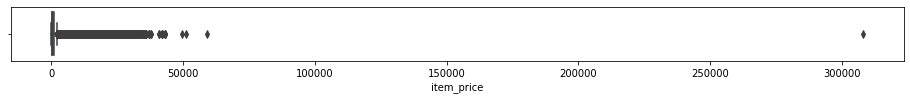

In [9]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_price)

#### Creating new data frame for only 2013,2014,2015

In [10]:
df_2013=df[(df.date<"01-01-2014") & ("31-12-2012"<df.date)]
df_2014=df[(df.date<"01-01-2015") & ("31-12-2013"<df.date)]
df_2015=df[(df.date<"01-01-2016") & ("31-12-2014"<df.date)]

** Grouping monthly sales **

In [11]:
df_2013['total_income_13']=df_2013.item_price*df_2013.item_cnt_day
df13_total=df_2013.groupby(['date_block_num']).sum()

df_2014['total_income_14']=df_2014.item_price*df_2014.item_cnt_day
df14_total=df_2014.groupby(['date_block_num']).sum()

df_2015['total_income_15']=df_2015.item_price*df_2015.item_cnt_day
df15_total=df_2015.groupby(['date_block_num']).sum()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

** Plot by total income for 2013 and 2014**

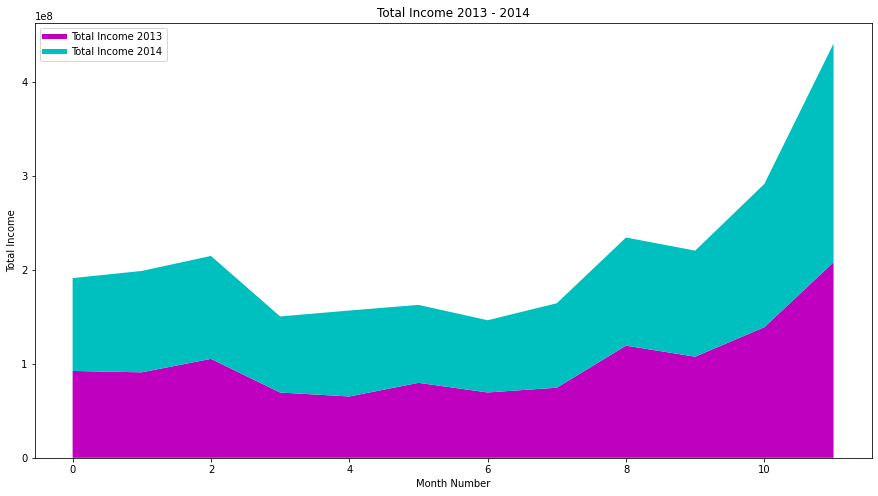

In [12]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='m', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='c', label='Total Income 2014', linewidth=5)

plt.stackplot(df13_total.index, df13_total.total_income_13, df14_total.total_income_14,colors=['m','c'])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

** Total Income Plotting Until October in 2013,2014 and 2015 **

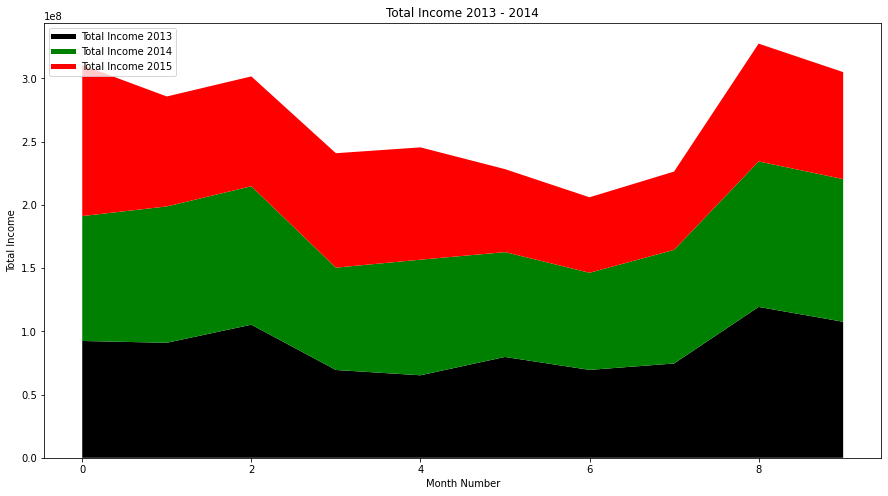

In [13]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='k', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='g', label='Total Income 2014', linewidth=5)
plt.plot([],[],color='r', label='Total Income 2015', linewidth=5)

plt.stackplot(df13_total.index[:10], df13_total.loc[:9].total_income_13, 
    df14_total.loc[:21].total_income_14,df15_total.total_income_15,colors=['k','g',"r"])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

#### Interesting with shop id

Finding different shops between years 2013, 2014 and 2015

In [14]:
set_difference_13_14 = set(df_2013.shop_id.unique()) - set(df_2014.shop_id.unique())
difference_13_14 = list(set_difference_13_14)

set_difference_13_15 = set(df_2013.shop_id.unique()) - set(df_2015.shop_id.unique())
difference_13_15 = list(set_difference_13_15)

difference_13_14.extend(difference_13_15)
difference_13=difference_13_14
difference_13

[0, 1, 32, 8, 23, 0, 1, 32, 8, 13, 23]

In [15]:
set_difference_14_15 = set(df_2014.shop_id.unique()) - set(df_2015.shop_id.unique())
difference_14_15 = list(set_difference_14_15)

set_difference_14_13 = set(df_2014.shop_id.unique()) - set(df_2013.shop_id.unique())
difference_14_13 = list(set_difference_14_13)

difference_14_13.extend(difference_14_15)
difference_14=difference_14_13
difference_14

[33, 34, 39, 40, 48, 20, 13]

In [16]:
set_difference_15_13 = set(df_2015.shop_id.unique()) - set(df_2013.shop_id.unique())
difference_15_13 = list(set_difference_15_13)

set_difference_15_14 = set(df_2015.shop_id.unique()) - set(df_2014.shop_id.unique())
difference_15_14 = list(set_difference_15_14)

difference_15_14.extend(difference_15_13)
difference_15=difference_15_14
difference_15

[11, 36, 33, 34, 36, 39, 40, 11, 48, 20]

In [17]:
# Dropping different shops from 2013 and 2014
df_2013_drop_shops=df_2013.groupby(["shop_id"]).sum().drop(difference_13, axis=0)
df_2014_drop_shops=df_2014.groupby(["shop_id"]).sum().drop(difference_14, axis=0)
df_2015_drop_shops=df_2015.groupby(["shop_id"]).sum().drop(difference_15, axis=0)

** Plot Total Income Per Shop **

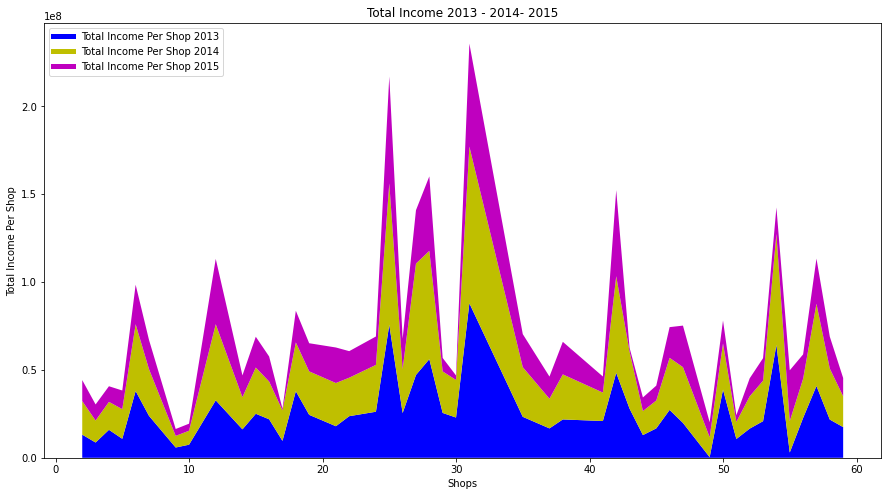

In [18]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='b', label='Total Income Per Shop 2013', linewidth=5)
plt.plot([],[],color='y', label='Total Income Per Shop 2014', linewidth=5)
plt.plot([],[],color='m', label='Total Income Per Shop 2015', linewidth=5)

plt.stackplot(df_2013_drop_shops.index, df_2013_drop_shops.total_income_13, 
    df_2014_drop_shops.total_income_14,df_2015_drop_shops.total_income_15,colors=['b','y',"m"])

plt.xlabel('Shops')
plt.ylabel('Total Income Per Shop')
plt.title('Total Income 2013 - 2014- 2015')
plt.legend(loc='upper left')
plt.show()

#### Creating Geo Data

In [19]:
#shop_names= lambda x: x.split(" ")[1]
#df_shops.shop_name.map(shop_names)

**Dropping duplicate shops**

10 and 11  Жуковский ул. Чкалова 39м?

РостовНаДону ТРК "Мегацентр Горизонт" Островной 39 40  

Москва ТК "Буденовский" (пав.К7) ??



In [20]:
df_shops=df_shops.drop([10,39,0]).reset_index()

** Identifying Online Shops **

In [21]:
df_shops["Online_Shops"]=0
df_shops.loc[df_shops.shop_id==9,"Online_Shops"]=1
df_shops.loc[df_shops.shop_id==20,"Online_Shops"]=1
df_shops.loc[df_shops.shop_id==55,"Online_Shops"]=1

** Identifying Cities **

In [88]:
#Cleaning shop name
df_shops['cleaned'] = [df_shops['shop_name'][i].replace('!', '').replace('?', '')
    .replace('²', '').replace('" ', ' ').replace(' "', ' ').replace('"', '')
    .replace('-', ' ').strip() for i in range(df_shops.shape[0])]


cities= lambda x: x.split(" ")[0]
df_shops["city"]=df_shops.cleaned.map(cities)
for i in range(len(df_shops["city"])):
    if df_shops["city"][i]=="St.":
        df_shops["city"][i]="Saint Petersburg"
    if df_shops["city"][i]=="Adygeya":
        df_shops["city"][i]="Tul’skiy"

df_shops.replace(, )
df_shops=df_shops.replace(["St.","Adygea","N.Novgorod"], ["Saint Petersburg","Tul’skiy","Nizhniy Novgorod"])
#

df_shops

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


shop_name  shop_id  \
0                  ! Yakutsk Ordzhonikidze, 56 francs        0   
1                         ! Yakutsk TC "Central" fran        1   
2                                    Adygea TC "Mega"        2   
3                     Balashikha TC "Oktyabr-Kinomir"        3   
4                               Volga TC "Volga Mall"        4   
5                              Vologda SEC "Marmelad"        5   
6                       Voronezh (Plekhanovskaya, 13)        6   
7                             Voronezh SEC "Maksimir"        7   
8                       Voronezh SEC City-Park "Grad"        8   
9                                      Outbound Trade        9   
10                         Zhukovsky st. Chkalov 39m?       10   
11                         Zhukovsky st. Chkalov 39m²       11   
12              Internet-shop of emergency situations       12   
13                                 Kazan TC "Behetle"       13   
14                            Kazan TC "ParkHouse" II       14   
15                            Kaluga TC "XXI century"       15   
16                                   Kolomna TC "Rio"       16   
17                     Krasnoyarsk TC "Vzletka Plaza"       17   
18                              Krasnoyarsk TC "June"       18   
19                           Kursk TC " Pushkinskiy "       19   
20                                     Moscow" Sale "       20   
21                            Moscow MTRC" Afi Mall "       21   
22                                    Moscow Shop C21       22   
23                   Moscow TK" Budenovskiy "(pav.A2)       23   
24                   Moscow TK" Budenovskiy "(pav.K7)       24   
25                               Moscow TEC" Atrium "       25   
26                      Moscow TTS" Areal "(Belyaevo)       26   
27                  Moscow TC" MEGA Belaya Dacha II "       27   
28                     Moscow TC" MEGA Teply Stan "II       28   
29                   Moscow TC" New Age "(Novokosino)       29   
30                             Moscow TC" Perlovsky "       30   
31                            Moscow TC" Semenovsky "       31   
32                      Moscow TC" Serebryany House "       32   
33                              Mytishchi SEC" XL-3 "       33   
34                              N.Novgorod SEC" RIO "       34   
35                          N.Novgorod SEC" Fantasy "       35   
36             Novosibirsk SEC" Gallery Novosibirsk "       36   
37                            Novosibirsk SEC" Mega "       37   
38                                    Omsk TC" Mega "       38   
39               RostovNaDonu SEC" Megacenter Horizon       39   
40   RostovNaDon Megatsentr Gorizont Ostrovnoy sho...       40   
41                   RostovNaDon Mega shopping center       41   
42       St. Petersburg Nevsky Center shopping center       42   
43             St. Petersburg Sennaya shopping center       43   
44                      Samara Melody shopping center       44   
45                   Samara ParkHouse shopping center       45   
46                  Sergiev Posad 7Ya shopping center       46   
47                             Surgut SEC "City Mall"       47   
48                           Tomsk SEC "Emerald City"       48   
49                               Tyumen SEC "Crystal"       49   
50                               Tyumen SEC "Goodwin"       50   
51                           Tyumen TC "Green Coast "       51   
52                                  Ufa TC" Central "       52   
53                                  Ufa TC" Family "2       53   
54                                  Khimki TC" Mega "       54   
55                        Digital warehouse 1C-Online       55   
56                             Chekhov TC" Karnaval "       56   
57                          Yakutsk Ordzhonikidze, 56       57   
58                              Yakutsk TC" Central "       58   
59                             Yaroslavl TC" Altair "       59   

                 

In [34]:
latitude_list, longitude_list=[],[]

for i in df_shops.cleaned:

    geolocator = Nominatim(user_agent="foursquare_agent")
    
    #geolocator = Nominatim(user_agent="my_user_agent")
    location = geolocator.geocode(i)
    try:
        latitude = location.latitude
        latitude_list.append(latitude)
    except:
        latitude_list.append(np.nan)

    try:    
        longitude = location.longitude
        longitude_list.append(longitude)
    except:
        longitude_list.append(np.nan)

df_shops["latitude"]=latitude_list
df_shops["longitude"]=longitude_list



### Russia Population Dataset

In [24]:
df_pop=pd.read_csv("/work/Data_Sets/competitive-data-science-predict-future-sales/ru_population.csv")
df_pop

city      lat      lng country iso2               admin_name  \
0              Moscow  55.7558  37.6178  Russia   RU                   Moskva   
1    Saint Petersburg  59.9500  30.3167  Russia   RU          Sankt-Peterburg   
2         Novosibirsk  55.0333  82.9167  Russia   RU   Novosibirskaya Oblast’   
3       Yekaterinburg  56.8356  60.6128  Russia   RU    Sverdlovskaya Oblast’   
4    Nizhniy Novgorod  56.3269  44.0075  Russia   RU  Nizhegorodskaya Oblast’   
..                ...      ...      ...     ...  ...                      ...   
718       Pokrovskoye  56.6897  28.2548  Russia   RU       Pskovskaya Oblast’   
719        Remontnoye  46.5614  43.6501  Russia   RU      Rostovskaya Oblast’   
720               Uni  57.7510  51.4913  Russia   RU       Kirovskaya Oblast’   
721         Zavetnoye  47.1194  43.8903  Russia   RU      Rostovskaya Oblast’   
722  Sebezhskiy Rayon  56.2500  28.5000  Russia   RU       Pskovskaya Oblast’   

     capital  population  population_proper  
0    primary  17125000.0         13200000.0  
1      admin   5351935.0          5351935.0  
2      admin   1602915.0          1602915.0  
3      admin   1468833.0          1468833.0  
4      admin   1264075.0          1264075.0  
..       ...         ...                ...  
718    minor         NaN                NaN  
719    minor         NaN                NaN  
720    minor         NaN                NaN  
721    minor         NaN                NaN  
722    minor         NaN                NaN  

[723 rows x 9 columns]

cities_pop_list=[] #matched list
pop_list=[] #population list
cap_list=[] #capital list
df_shops["population"]=0
df_shops["capital"]=0

for i in range(len(cities_list)): 
    for j in range(len(df_pop.city)):
        if df_pop.city[j]==cities_list[i]:
            #print(cities_list[i])

            cities_pop_list.append(i)

            df_shops.loc[df_shops.Cities==cities_list[i],"population"]=df_pop.city.loc[df_pop.city==cities_list[i]]
print(len(cities_pop_list))
df_shops


In [80]:
city_difference= set(df_shops.city.unique())-set(df_pop.city.unique())
city_difference

{'Adygea',
 'Digital',
 'Internet',
 'N.Novgorod',
 'Outbound',
 'RostovNaDon',
 'RostovNaDonu',
 'Sergiev',
 'Volga',
 'Zhukovsky'}

In [77]:
df_pop[df_pop.city.isin(df_shops.city)]
pd.merge(df_pop, df_shops, on=['city'])

city      lat       lng country iso2  \
0             Moscow  55.7558   37.6178  Russia   RU   
1             Moscow  55.7558   37.6178  Russia   RU   
2             Moscow  55.7558   37.6178  Russia   RU   
3             Moscow  55.7558   37.6178  Russia   RU   
4             Moscow  55.7558   37.6178  Russia   RU   
5             Moscow  55.7558   37.6178  Russia   RU   
6             Moscow  55.7558   37.6178  Russia   RU   
7             Moscow  55.7558   37.6178  Russia   RU   
8             Moscow  55.7558   37.6178  Russia   RU   
9             Moscow  55.7558   37.6178  Russia   RU   
10            Moscow  55.7558   37.6178  Russia   RU   
11            Moscow  55.7558   37.6178  Russia   RU   
12            Moscow  55.7558   37.6178  Russia   RU   
13  Saint Petersburg  59.9500   30.3167  Russia   RU   
14  Saint Petersburg  59.9500   30.3167  Russia   RU   
15       Novosibirsk  55.0333   82.9167  Russia   RU   
16       Novosibirsk  55.0333   82.9167  Russia   RU   
17             Kazan  55.7908   49.1144  Russia   RU   
18             Kazan  55.7908   49.1144  Russia   RU   
19              Omsk  54.9667   73.3833  Russia   RU   
20            Samara  53.1833   50.1167  Russia   RU   
21            Samara  53.1833   50.1167  Russia   RU   
22               Ufa  54.7333   55.9667  Russia   RU   
23               Ufa  54.7333   55.9667  Russia   RU   
24       Krasnoyarsk  56.0167   92.8667  Russia   RU   
25       Krasnoyarsk  56.0167   92.8667  Russia   RU   
26          Voronezh  51.6717   39.2106  Russia   RU   
27          Voronezh  51.6717   39.2106  Russia   RU   
28          Voronezh  51.6717   39.2106  Russia   RU   
29            Tyumen  57.1500   65.5333  Russia   RU   
30            Tyumen  57.1500   65.5333  Russia   RU   
31            Tyumen  57.1500   65.5333  Russia   RU   
32         Yaroslavl  57.6167   39.8500  Russia   RU   
33             Tomsk  56.4886   84.9522  Russia   RU   
34        Balashikha  55.8000   37.9500  Russia   RU   
35             Kursk  51.7372   36.1872  Russia   RU   
36            Surgut  61.2500   73.4333  Russia   RU   
37            Kaluga  54.5333   36.2667  Russia   RU   
38           Vologda  59.2167   39.9000  Russia   RU   
39           Yakutsk  62.0272  129.7319  Russia   RU   
40           Yakutsk  62.0272  129.7319  Russia   RU   
41           Yakutsk  62.0272  129.7319  Russia   RU   
42           Yakutsk  62.0272  129.7319  Russia   RU   
43            Khimki  55.8892   37.4450  Russia   RU   
44         Mytishchi  55.9167   37.7333  Russia   RU   
45           Kolomna  55.0833   38.7833  Russia   RU   
46           Chekhov  55.1481   37.4769  Russia   RU   

                                  admin_name capital_x  population_x  \
0                                     Moskva   primary    17125000.0   
1                                     Moskva   primary    17125000.0   
2                                     Moskva   primary    17125000.0   
3                                     Moskva   primary    17125000.0   
4                                     Moskva   primary    17125000.0   
5                                     Moskva   primary    17125000.0   
6                                     Moskva   primary    17125000.0   
7                                     Moskva   primary    17125000.0   
8                                     Moskva   primary    17125000.0   
9                                     Moskva   primary    17125000.0   
10                                    Moskva   primary    17125000.0   
11                                    Moskva   primary    17125000.0   
12                                    Moskva   primary    17125000.0   
13                           Sankt-Peterburg     admin     5351935.0   
14                           Sankt-Peterburg     admin     5351935.0   
15                    Novosibirskaya Oblast’     admin     1602915.0   
16                    Novosibirskaya Oblast’     admin     1602915.0   
17                             

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=796ba814-f632-4502-b0d7-7e2f8f9e546d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>